In [209]:
from eztao.carma import DRW_term, DHO_term
from eztao.ts import gpSimRand, gpSimFull, drw_fit, dho_fit
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import photRM

In [ ]:
###### how does the convolution work? 

np.random.seed(0)

# generate a continuum light curve (x-band)
tc, fxc, errxc, rblr = photRM.LC_conti(6000)

# if you want to specify a time-lag (size of the BLR):
#tc, fxc, errxc, rblr = photRM.LC_conti(6000, rblr_flag=True, lag=42)

# use obtained continuum light curve to generate a continuum+line light curve (y-band)
x_band, y_band, line_response = photRM.LC_two_bands(tc, fxc, errxc, rblr)

In [210]:
os.chdir('/Users/mattlowery/Desktop/code/astro/hetvae/src/reverberation_mapping/fortran_dir/3C_273_data')

B = '3C273_B'
G = '3C273_G'
V = '3C273_V'
R = '3C273_R'
I = '3C273_I'
Z = '3C273_Z'

In [211]:
B_df = pd.read_csv(B, sep=' ', header=None).sort_values(0)

In [212]:
B_df.columns = {'t':0,'mag':1,'magerr':2}

In [213]:
B_df.tail()

,t,mag,magerr
210,59434.990279,18.640255,0.227
211,59435.729725,18.348327,0.248
212,59435.730422,18.134334,0.248
213,59436.723439,18.179174,0.356
214,59436.724089,18.284681,0.356


In [218]:
t = B_df['t'].to_numpy()
y = B_df['mag'].to_numpy() # .mean()
yerr = B_df['magerr'].to_numpy()

In [219]:
# SNR is ratio between CARMA RMS amplitude and
# the median of the measurement errors (simulated using log normal).
RMS = np.sqrt(np.mean(np.square(B_df['mag'])))
SNR = RMS / np.median(B_df['magerr'])

In [220]:
best_fit = dho_fit(t, y, yerr)
print(f'Best-fit DRW parameters: {best_fit}')
log_bf =  np.log(best_fit)

Best-fit DRW parameters: [3.24494835 0.4129514  0.45521499 0.49891822]


In [221]:
B_df['t'] = B_df['t'] - B_df['t'][0]

In [238]:
x = [np.array([[10,1]])[np.newaxis,np.newaxis], np.array([[10,1]])[np.newaxis,np.newaxis]]
np.concatenate(x, axis=0).shape

(2, 1, 1, 2)

In [205]:
DHO_kernel =  DHO_term(*log_bf)
# SNR, duration, N
t, y, yerr = gpSimFull(DHO_kernel,SNR, 260, 260) # this is just not the right scale wtf 
sim_df = pd.DataFrame([t,y,yerr]).T
sim_df.columns = {'t':0, 'mag':1, 'magerr':2}

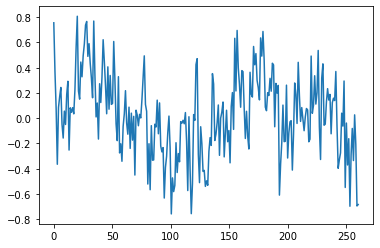

In [206]:
plt.plot(t,y)

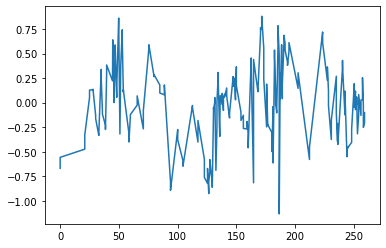

In [208]:
plt.plot(B_df['t'], B_df['mag']- B_df['mag'].mean())

In [173]:
from scipy import interpolate

def interp(a,b):
    new_b = pd.DataFrame(columns=['t', 'mag', 'magerr'])
    # nearest, extrapolate 
    f0 = interpolate.interp1d(b['t'], b['mag'], kind='quadratic',fill_value="extrapolate")
    f1 = interpolate.interp1d(b['t'], b['magerr'], kind='quadratic',fill_value="extrapolate")
    new_b['mag'] = f0(a['t'])
    new_b['magerr'] = f1(a['t'])
    new_b['t'] = a['t']
    return new_b


In [197]:
f = interpolate.interp1d(sim_df['t'], sim_df['mag'],fill_value="extrapolate")

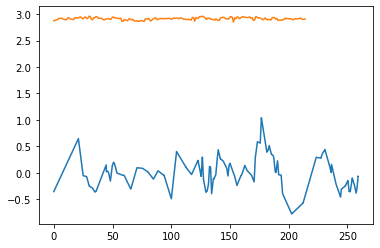

In [201]:
plt.plot(B_df['t'], f(B_df['t']), '-', np.log(B_df['mag']))

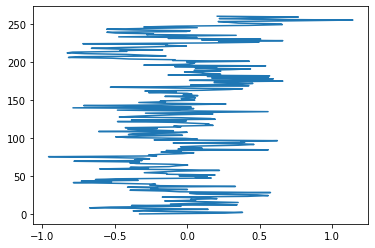

In [192]:
plt.plot(sim_df['t'], sim_df['mag'])

In [174]:
new_sim = interp(B_df, sim_df)

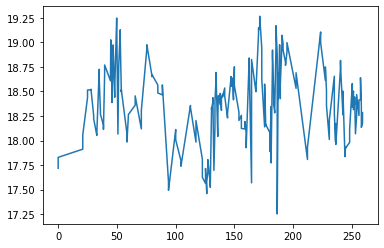

In [175]:
plt.plot(B_df['t'], B_df['mag'])

In [176]:
new_sim.head()

,t,mag,magerr
0,0.000000,1.134982e+02,0.004545
1,0.001009,8.838020e+01,0.004541
2,20.952008,2.686514e+07,-180.620260
3,20.953005,2.686782e+07,-180.638275
4,25.012346,3.888390e+07,-261.432604


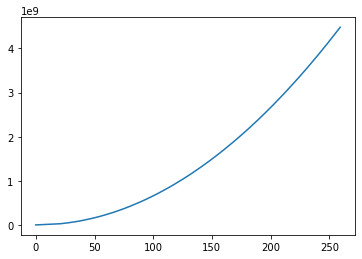

In [177]:
plt.plot(new_sim['t'], new_sim['mag'])